In [1]:
# Подлюкчение гугл диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# импорты
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from os.path import isfile, join
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
device = "cuda"

# функция чтения данных
def read_data(idx: int):
    with open(f'/content/drive/MyDrive/Colab Notebooks/Хакатон Я-профи 2023/train/X/{idx}.pkl', 'rb') as f:
        x = pickle.load(f)
    with open(f'/content/drive/MyDrive/Colab Notebooks/Хакатон Я-профи 2023/train/Y/{idx}.pkl', 'rb') as f:
        y_elements, y_defects = pickle.load(f)
    return x, y_elements, y_defects

def read_data_test(idx: int):
    with open(f'/content/drive/MyDrive/Colab Notebooks/Хакатон Я-профи 2023/test/X/{idx}.pkl', 'rb') as f:
        x = pickle.load(f)
    return x

In [3]:
# все файлы из папки
mypath = '/content/drive/MyDrive/Colab Notebooks/Хакатон Я-профи 2023/train/X'
onlyfiles = [f for f in os.listdir(mypath) if isfile(join(mypath, f))] # все файлы из папки

In [4]:
len(onlyfiles)

1001

In [5]:
# пример данных
data = read_data(1023025)  # 6294811, 1016718, 1018304, 1023025, 2829189, 3333187, 4240666, 5673298, 8183362, 2512901

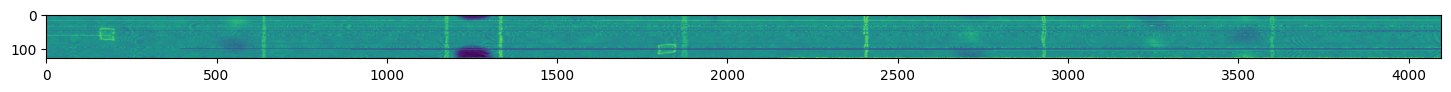

In [83]:
plt.figure(figsize=(18, 8))
plt.imshow(data[0]);

In [6]:
# Переводим в .png
plt.imsave('image.png', data[0])

In [7]:
# обработка изображения с openCV
def algorithm_class2(img, a=70, b=140, c=140, d=190):

  img_contours = img.copy()

  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # разные параметры для разных картинок
  lower = np.array([a, b, c], dtype="uint8")   # 70, 140, 140
  upper = np.array([100, d, 170], dtype="uint8")   # 100, 190, 172
  thresh = cv2.inRange(hsv, lower, upper)

  # ищем контуры
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # фильтруем по площади
  large_contours = []
  for contour in contours:
      if contour[len(contour)//2][0][0] - contour[0][0][0] > 100:
          pass
      elif 5000 > cv2.contourArea(contour) > 300:
          large_contours.append(contour)
  if d <= b:
    return []

  if len(large_contours) > 20 or len(large_contours) <= 0:
    large_contours = algorithm_class2(img, d = d - 5)


  return large_contours

  # 3 class: 70, 120, 140; 120, 180, 162

In [8]:
# обработка изображения с openCV
def algorithm_class3(img, a=160):

  img_contours = img.copy()

  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # разные параметры для разных картинок
  lower = np.array([100, 120, 130], dtype="uint8")   # 100, 120, 130
  upper = np.array([160, a, 210], dtype="uint8")   # 160, 160, 210
  thresh = cv2.inRange(hsv, lower, upper)

  # находим контуры
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # фильтруем по площади
  large_contours = []
  for contour in contours:
    if abs(contour[len(contour) // 2][0][0] - contour[0][0][0]) > 500:
      pass
    elif 5000 > cv2.contourArea(contour) > 50:
        large_contours.append(contour)
  return large_contours

In [9]:
# обработка изображения с openCV
def algorithm_class1(img):

  img_contours = img.copy()

  # пытались добавлять blur, но точность падает
  # img = cv2.medianBlur(img, 3)
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # разные параметры для разных картинок
  lower = np.array([40, 140, 170], dtype="uint8")   # 40, 140, 170
  upper = np.array([90, 190, 210], dtype="uint8")   # 90, 190, 210
  thresh = cv2.inRange(hsv, lower, upper)

  # поиск контуров
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # отбор по площади
  large_contours = []
  for contour in contours:
      if 1000 > cv2.contourArea(contour) > 2:
          large_contours.append(contour)
  return large_contours

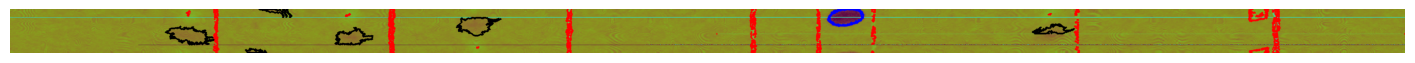

In [10]:
# просмотр получившихся контуров предсказанных классов на одной картинке
image = cv2.imread('image.png')
large_contours2 = algorithm_class2(np.array(image))
large_contours1 = algorithm_class1(np.array(image))
large_contours3 = algorithm_class3(np.array(image))
img = image.copy()

cv2.drawContours(img, large_contours2, -1, (0, 0, 0), 3)
for contour in large_contours1:
  cv2.drawContours(img, contour, -1, (255, 0, 0), 3)
cv2.drawContours(img, large_contours3, -1, (0, 0, 255), 3)

plt.figure(figsize=(18, 8))
plt.axis('off')
plt.imshow(img);

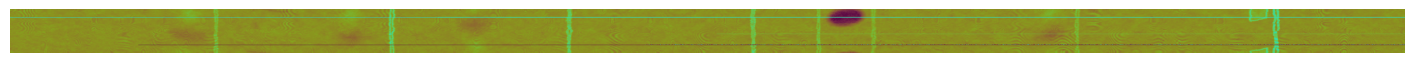

In [54]:
# оригинальная картинка
plt.figure(figsize=(18, 8))
plt.axis('off')
plt.imshow(image);

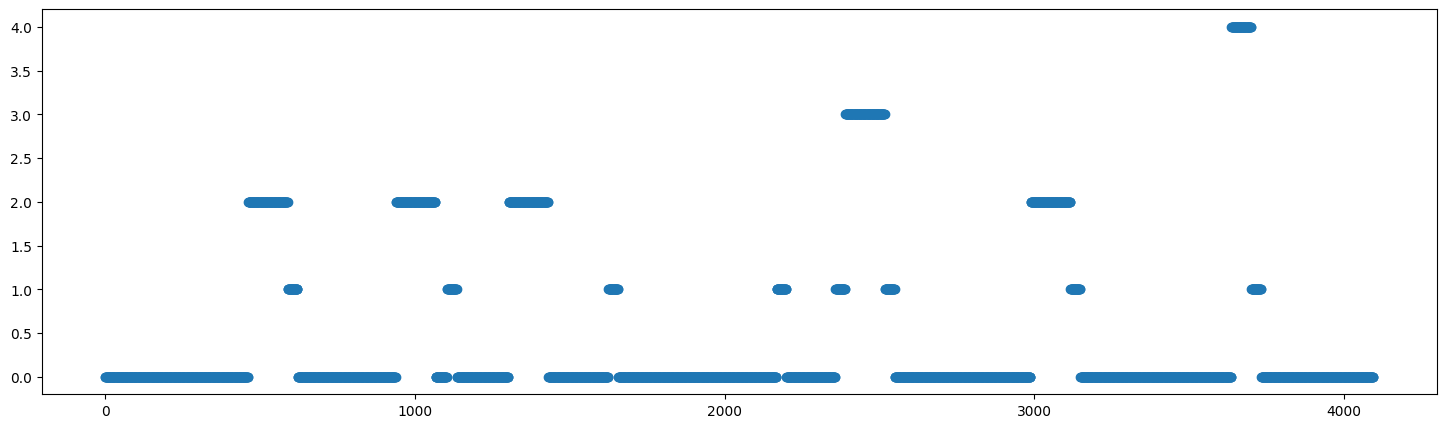

In [55]:
# тренировочные классы для элементов
plt.figure(figsize=(18, 5))
plt.scatter([i for i in range(4096)], data[1]);

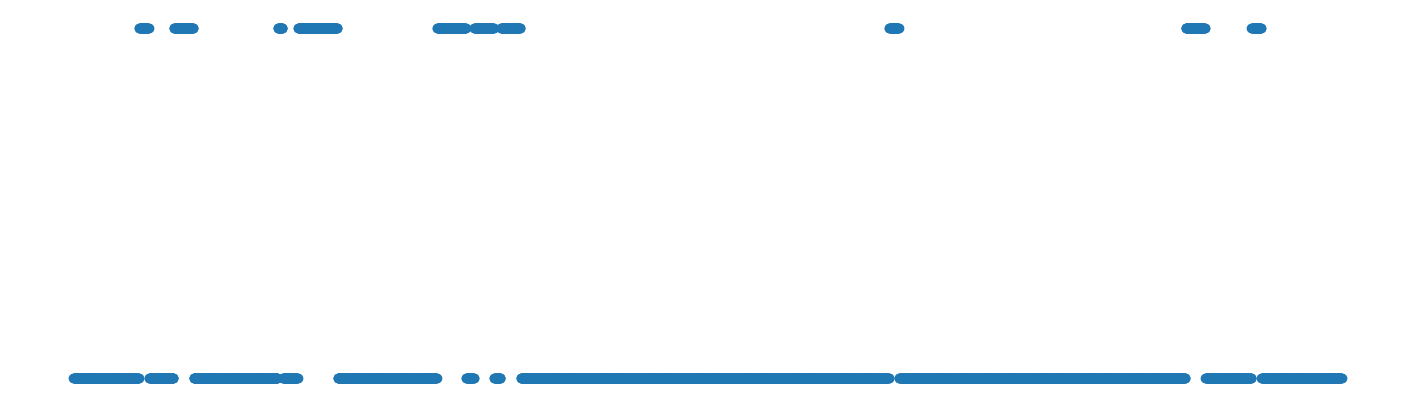

In [13]:
# тренировочные классы для дефектов
plt.figure(figsize=(18, 5))
plt.axis('off')
plt.scatter([i for i in range(4096)], data[2]);

Валидация параметров модели

In [ ]:
i = 0
scores = []
for file in onlyfiles:
  data = read_data(file[:-4])
  plt.imsave(file[:-4] + '.png', data[0])
  image = cv2.imread(file[:-4] + '.png')

  # некоторые картинки в другой цветовой гамме. Там мы меняем немного модели
  if np.median(image) < 130:
    large_contours2 = algorithm_class3(np.array(image), a=140)
    large_contours1 = algorithm_class1(np.array(image))
    large_contours3 = []

  else:
    large_contours2 = algorithm_class2(np.array(image))
    large_contours1 = algorithm_class1(np.array(image))
    large_contours3 = algorithm_class3(np.array(image))

  img = image.copy()

  # рисуем контуры
  # cv2.drawContours(img, large_contours3, -1, (0, 0, 0), 3)
  # cv2.drawContours(img, large_contours2, -1, (0, 0, 0), 3)
  # cv2.drawContours(img, large_contours1, -1, (0, 0, 0), 3)

  # отрисовка картинок
  # plt.figure(figsize=(18, 8))
  # plt.axis('off')
  # plt.imshow(img);

  # plt.figure(figsize=(18, 8))
  # plt.axis('off')
  # plt.imshow(image);

  # создаём массив ответов
  y_pred = np.array([0]*4096)

  contours1 = np.array([0]*4096)

  for contour in large_contours1:
    for dot in contour:
      if dot[0][0] > 4095:
        pass
      else:
        contours1[dot[0][0]] += 1
  
  # Если точек от 2 до 10, то это заплатка
  y_pred[2 <= contours1] = 4

  # Если в столбце точек более 10, то это шов
  y_pred[contours1 > 10] = 1

  contours2 = np.array([0]*4096)

  for contour in large_contours2:
    for dot in contour:
      if dot[0][0] > 4095:
        pass
      else:
        y_pred[dot[0][0]] = 2
  
  for contour in large_contours3:
    for dot in contour:
      if dot[0][0] > 4095:
        pass
      else:
        y_pred[dot[0][0]] = 3

  def F1(pr, rec):
    return 2 / (1 / (pr) + 1 / (rec))
  def F2(pr,rec):
    return 4/(3 / rec + (1 / (min(0.9, pr) / 0.9)))
  def Q(pr1,rec1,pr2,rec2):
    return (F1(pr1,rec1) + 2 * F2(pr2,rec2))/3
  prec = precision_score(data[1][:4096], y_pred, average='macro', zero_division=0)
  rec = recall_score(data[1][:4096], y_pred, average='macro', zero_division=0)
  
  i += 1
  scores.append(F1(prec, rec))
  if i > 500:
    break
  
print(np.mean(scores))
# 0.704

Тестовые данные

In [12]:
mypath_test = '/content/drive/MyDrive/Colab Notebooks/Хакатон Я-профи 2023/test/X'
onlyfiles_test = [f for f in os.listdir(mypath_test) if isfile(join(mypath_test, f))] # все файлы из папки

In [13]:
len(onlyfiles_test)

100

In [33]:
df = pd.DataFrame()
for file in onlyfiles_test:
  data = read_data_test(file[:-4])
  plt.imsave(file[:-4] + '.png', data)
  image = cv2.imread(file[:-4] + '.png')

  # некоторые картинки в другой цветовой гамме. Там мы меняем немного модели
  if np.median(image) < 130:
    large_contours2 = algorithm_class3(np.array(image), a=140)
    large_contours1 = algorithm_class1(np.array(image))
    large_contours3 = []

  else:
    large_contours2 = algorithm_class2(np.array(image))
    large_contours1 = algorithm_class1(np.array(image))
    large_contours3 = algorithm_class3(np.array(image))

  img = image.copy()

  y_pred = np.array([0]*4096)

  contours1 = np.array([0]*4096)

  for contour in large_contours1:
    for dot in contour:
      if dot[0][0] > 4095:
        pass
      else:
        contours1[dot[0][0]] += 1
  
  y_pred[2 <= contours1] = 4
  y_pred[contours1 > 10] = 1

  for contour in large_contours2:
    for dot in contour:
      if dot[0][0] > 4095:
        pass
      else:
        y_pred[dot[0][0]] = 2
  
  for contour in large_contours3:
    for dot in contour:
      if dot[0][0] > 4095:
        pass
      else:
        y_pred[dot[0][0]] = 3

  y_def = [0]*4096
  y_pred = list(y_pred)
  # сохранение тестовых данных
  with open(mypath_test[:-1] + 'Y/' + file, 'wb') as f:
    pickle.dump([y_pred, y_def], f)

SAM model

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

In [4]:
# функция для отображения масок
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    sorted_anns = [mask for mask in sorted_anns if 10000 > mask['area']]
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.zeros((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.6)))

In [ ]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [6]:
# Перед установкой надо скачать веса модели с их сайта, ссылка есть на главной
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
sam = sam_model_registry["vit_b"](checkpoint="/content/drive/MyDrive/Colab Notebooks/sam_vit_b_01ec64.pth").to(device) # checkpoint - ссылка на веса модели
mask_generator = SamAutomaticMaskGenerator(model=sam, pred_iou_thresh=0.5, stability_score_thresh=0.6, stability_score_offset=0.5)

def neural_net(image):
  masks = mask_generator.generate(image)
  return masks

In [11]:
# перевод в формат .png и автоматический поиск масок на картинке
plt.imsave('image.png', data[0])
image = cv2.imread('image.png')
masks = neural_net(np.array(image))

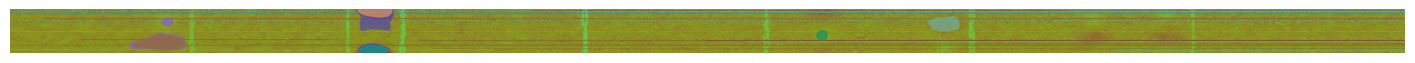

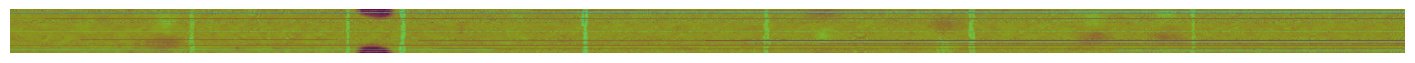

In [12]:
# отрисовка масок
plt.figure(figsize=(18, 8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 
plt.figure(figsize=(18, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

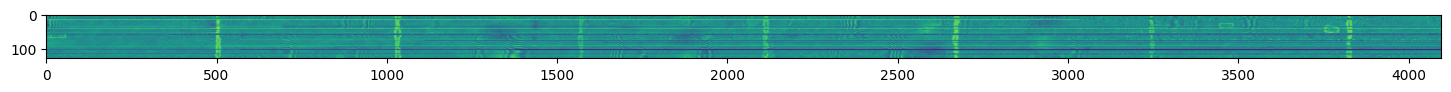

In [ ]:
# оригинальное изображение
plt.figure(figsize=(18, 8))
plt.imshow(data[0])